In [1]:
!gcloud config set project etsy-bigquery-adhoc-prod


If you have a compatible Python interpreter installed, you can use it by setting
the CLOUDSDK_PYTHON environment variable to point to it.

Updated property [core/project].


In [2]:
%load_ext google.cloud.bigquery

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Run the following in Bigquery
```
create table `etsy-sr-etl-prod.yzhang.visual_diversity_clipjoint_embedding` as (
  with train_data as (
    select distinct
        requestUUID, position, visitId,
        ctx.docInfo.queryInfo.query as query_str,
        ctx.docInfo.queryInfo.queryLevelMetrics.bin as query_bin,
        candidateInfo.docInfo.listingInfo.listingId as listing_id,
    from `etsy-ml-systems-prod.attributed_instance.query_pipeline_web_organic_2023_09_08`,
        unnest(contextualInfo) as ctx
    where ctx.docInfo.queryInfo.query is not null
    and candidateInfo.docInfo.listingInfo.listingId is not null
  ),
  embed_data as (
    select listing_id, joint_embedding_norm as embedding
    from `etsy-data-warehouse-prod.computer_vision.clip_joint_embeddings_latest`
    where listing_id in (
      select distinct listing_id from train_data
    )
  ),
  results as (
    select train_data.*, embed_data.embedding
    from train_data
    join embed_data
    on train_data.listing_id = embed_data.listing_id
  )
  select * from results  
)
```

Run dataflow job to get cosine sim

In [4]:
%%bigquery df
with query_gms as (
  select query, visit_id, sum(attributed_gms) as gms
  from `etsy-data-warehouse-prod.search.query_sessions_new`
  where _date = date('2023-09-08')
  group by query, visit_id
)
select vsv2_with_visit.*, gms
from vsv2_with_visit
left join query_gms
on vsv2_with_visit.query_str = query_gms.query
and vsv2_with_visit.visitId = query_gms.visit_id

Downloading: 100%|██████████████████| 846312/846312 [04:26<00:00, 3181.46rows/s]


In [5]:
df.head(n=3)

,requestUUID,query_str,query_bin,listing_ids,cosine_sim,visitId,gms
0,ee2aae38-5df8-44b5-bea7-e9a9b9710708,quilt for sale handmade,None,"[1236331178, 1531095982, 1477931836, 153106463...","[1.0000000000000002, 0.3164352481816841, 0.592...",6JGYpPu92b95VLKrY0uZmI4iXx2G.1694152661322.1,NaN
1,42513714-471b-4c0b-bdea-dd2a2f268de6,fox and butterfly patch,None,"[1005345403, 766767466, 1555373167, 1003673033...","[1.0000000000000002, 0.033967095553444765, 0.1...",L1XZI_x1X0SyUXYRiASr_sCO8rOV.1694161051452.2,NaN
2,82e986c8-4f2b-4006-893c-2c6d1643dd7a,alianza de boda,None,"[976559652, 976559652, 1225776292, 1225776292,...","[1.0000000000000002, 1.0000000000000002, 0.470...",23tuTxAR9BMfedQsPgl_ZkGUQLLH.1694151970047.2,NaN


In [6]:
df.shape

(846312, 7)

In [7]:
df[~df.gms.isna()].shape

(457798, 7)

# Distribution of similarity scores

In [12]:
## Overall - sample 10000 requests
df_sub = df.sample(n=10000, replace=False).reset_index(inplace=False)

In [13]:
all_scores = []
for i in tqdm(range(10000)):
    d = int(np.sqrt(len(df_sub.cosine_sim[i])))
    sim_mat = np.reshape(np.copy(df_sub.cosine_sim[i]), (d, d))
    np.fill_diagonal(sim_mat, np.nan)
    sim_scores = sim_mat.flatten()
    all_scores.append(sim_scores)

100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4089.36it/s]


<Axes: ylabel='Count'>

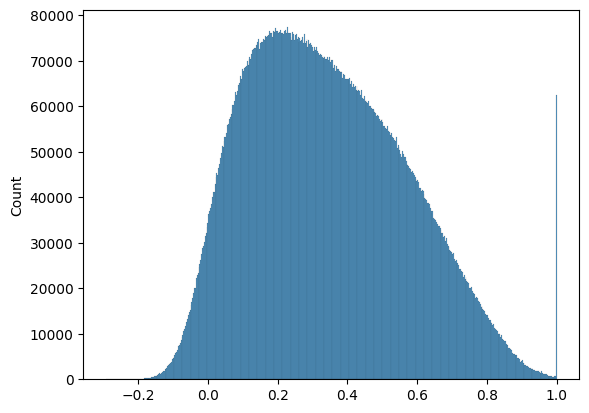

In [15]:
all_scores_flatten = np.concatenate(all_scores)
sns.histplot(all_scores_flatten)

In [16]:
## By query bin
df.query_bin.unique()

array([None, 'head', 'tail', 'top.1', 'torso', 'top.01'], dtype=object)

In [17]:
df_head = df[df.query_bin == "head"]; print(df_head.shape)
df_tail = df[df.query_bin == "tail"]; print(df_tail.shape)
df_torso = df[df.query_bin == "torso"]; print(df_torso.shape)
df_top1 = df[df.query_bin == "top.1"]; print(df_top1.shape)
df_top01 = df[df.query_bin == "top.01"]; print(df_top01.shape)

(247318, 7)
(51489, 7)
(68225, 7)
(153508, 7)
(183469, 7)


In [24]:
def get_sim_scores(data_df):
    all_scores = []
    for i in tqdm(range(data_df.shape[0])):
        d = int(np.sqrt(len(data_df.cosine_sim[i])))
        sim_mat = np.reshape(np.copy(data_df.cosine_sim[i]), (d, d))
        np.fill_diagonal(sim_mat, np.nan)
        sim_scores = sim_mat.flatten()
        all_scores.append(sim_scores[~np.isnan(sim_scores)])
    return np.concatenate(all_scores)

In [25]:
df_head_sub = df_head.sample(n=10000, replace=False).reset_index(inplace=False)
head_scores = get_sim_scores(df_head_sub)

df_tail_sub = df_tail.sample(n=10000, replace=False).reset_index(inplace=False)
tail_scores = get_sim_scores(df_tail_sub)

df_torso_sub = df_torso.sample(n=10000, replace=False).reset_index(inplace=False)
torso_scores = get_sim_scores(df_torso_sub)

df_top1_sub = df_top1.sample(n=10000, replace=False).reset_index(inplace=False)
top1_scores = get_sim_scores(df_top1_sub)

df_top01_sub = df_top01.sample(n=10000, replace=False).reset_index(inplace=False)
top01_scores = get_sim_scores(df_top01_sub)

100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 12905.98it/s]


In [32]:
print(np.min(top01_scores)); print(np.max(top01_scores))

-0.25392447772252347
1.0000000000000013


In [33]:
print(np.min(head_scores)); print(np.max(head_scores))

-0.2990471377509041
1.0000000000000013


In [34]:
print(np.min(tail_scores)); print(np.max(tail_scores))

-0.2810254762146495
1.0000000000000013


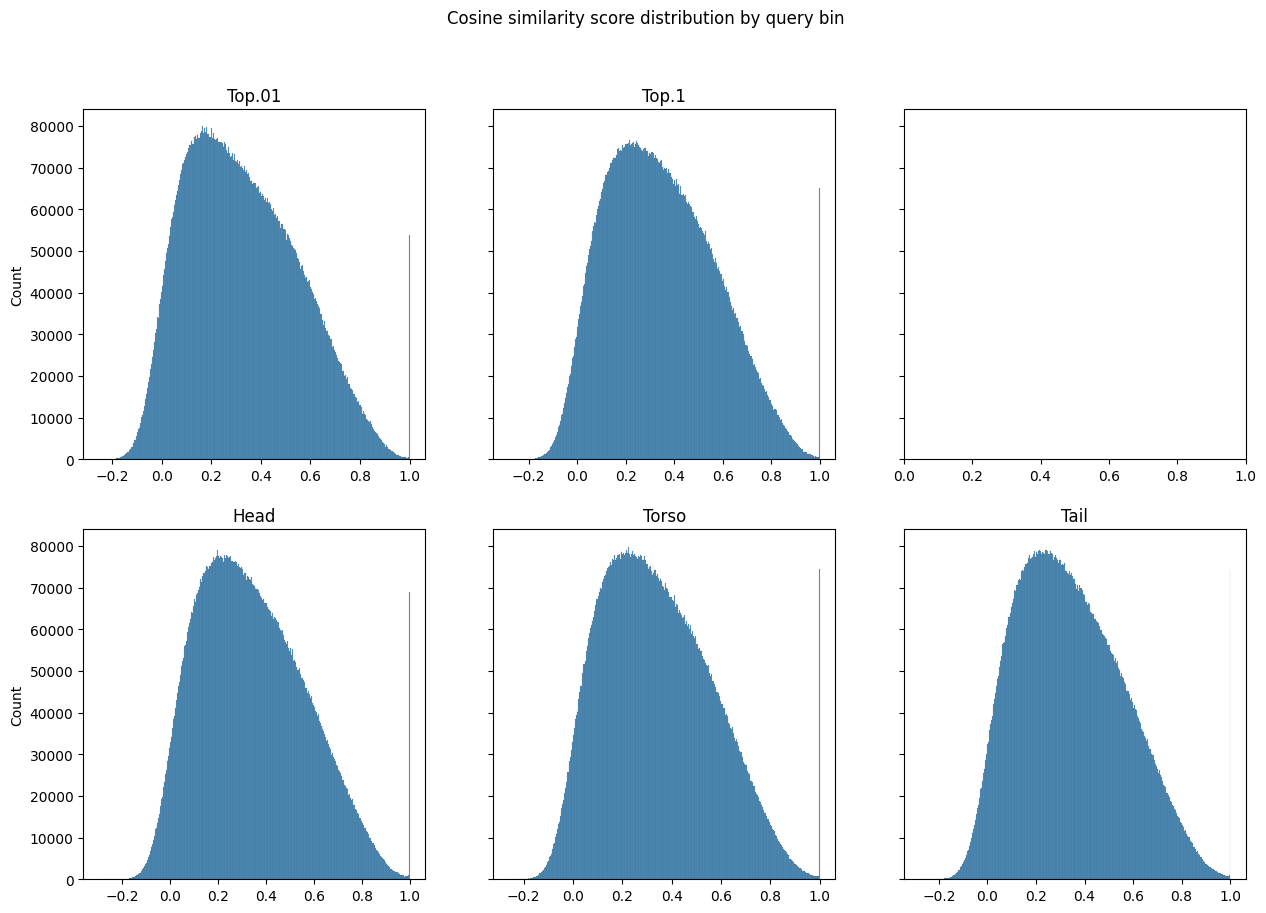

In [29]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True)
fig.suptitle('Cosine similarity score distribution by query bin')

sns.histplot(ax=axes[0, 0], data=top01_scores)
axes[0, 0].set_title("Top.01")

sns.histplot(ax=axes[0, 1], data=top1_scores)
axes[0, 1].set_title("Top.1")

sns.histplot(ax=axes[1, 0], data=head_scores)
axes[1, 0].set_title("Head")

sns.histplot(ax=axes[1, 1], data=torso_scores)
axes[1, 1].set_title("Torso")

sns.histplot(ax=axes[1, 2], data=tail_scores)
axes[1, 2].set_title("Tail")

plt.show()

# Threshold vs GMS

In [37]:
df_gms = df[~df.gms.isna()]
df_gms = df_gms[df_gms.gms > 0.]

In [39]:
df.gms.dropna().sum()

47595960.0

In [40]:
df_gms.gms.sum()

47595960.0

In [62]:
df_gms.shape

(22063, 8)

In [42]:
df_gms.reset_index(inplace=True)

In [67]:
thresholds = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2]
threshold_gms = {str(th): 0.0 for th in thresholds}

for i in tqdm(range(df_gms.shape[0])):
    d = int(np.sqrt(len(df_gms.cosine_sim[i])))
    sim_mat = np.reshape(np.copy(df_gms.cosine_sim[i]), (d, d))
    np.fill_diagonal(sim_mat, np.nan)
    sim_scores = sim_mat.flatten()
    offdiag_sim_scores = sim_scores[~np.isnan(sim_scores)]
    for k, v in threshold_gms.items():
        if np.any(offdiag_sim_scores > (1. - float(k))):
            threshold_gms[k] = v + df_gms.gms[i]

100%|███████████████████████████████████| 22063/22063 [00:02<00:00, 7444.08it/s]


In [68]:
threshold_gms

{'0.0001': 11902088.0,
 '0.001': 13320655.0,
 '0.01': 15866525.0,
 '0.05': 23237367.0,
 '0.1': 31704589.0,
 '0.2': 43396132.0}

# How discriminative are the scores

Sample 20 pairs of listings with sim score > thresholds

In [92]:
df_sampled = df.sample(n=10000, replace=False).reset_index(inplace=False)

In [93]:
thresholds = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2]
threshold_listings = {str(th): set() for th in thresholds}

for i in tqdm(range(df_sampled.shape[0])):
    d = int(np.sqrt(len(df_sampled.cosine_sim[i])))
    sim_mat = np.reshape(np.copy(df_sampled.cosine_sim[i]), (d, d))
    cand_listings = list(df_sampled.listing_ids[i])
    np.fill_diagonal(sim_mat, np.nan)
    
    for j in range(d):
        for k in range(j+1, d):
            for key, val in threshold_gms.items():
                if (sim_mat[j, k] > (1.0 - float(key))) and (cand_listings[j] != cand_listings[k]):
                    threshold_listings[key].add((cand_listings[j], cand_listings[k]))

100%|████████████████████████████████████| 10000/10000 [00:31<00:00, 321.01it/s]


In [94]:
[len(v) for v in threshold_listings.values()]

[2800, 3204, 4328, 11149, 32050, 168527]

In [95]:
val = threshold_listings["0.1"]

In [96]:
sampled_idx = np.random.choice(len(val), size=20, replace=False)

In [97]:
sampled_idx

array([30310,  8704,  7033, 31108,  6557, 10238, 24073, 15109, 23410,
         261,  5089,  1535, 26998, 13768,  3508, 31982, 11119, 19046,
         640,  9650])

In [99]:
for key, val in threshold_listings.items():
    print(key)
    val = list(val)
    sampled_idx = np.random.choice(len(val),size=20)
    sampled_val = [val[idx] for idx in sampled_idx]
    for i in range(len(sampled_val)):
        lid1 = sampled_val[i][0]
        lid2 = sampled_val[i][1]
        print(f"https://atlas.etsycorp.com/recsys/listing_viewer.php?listing_ids={lid1},{lid2}")

0.0001
https://atlas.etsycorp.com/recsys/listing_viewer.php?listing_ids=1096943818,1096926184
https://atlas.etsycorp.com/recsys/listing_viewer.php?listing_ids=1428523403,1477106489
https://atlas.etsycorp.com/recsys/listing_viewer.php?listing_ids=103524479,103523831
https://atlas.etsycorp.com/recsys/listing_viewer.php?listing_ids=1165881246,1225883870
https://atlas.etsycorp.com/recsys/listing_viewer.php?listing_ids=609007543,595167510
https://atlas.etsycorp.com/recsys/listing_viewer.php?listing_ids=1293133474,1338296406
https://atlas.etsycorp.com/recsys/listing_viewer.php?listing_ids=1545204834,1559385301
https://atlas.etsycorp.com/recsys/listing_viewer.php?listing_ids=1364105783,1364115129
https://atlas.etsycorp.com/recsys/listing_viewer.php?listing_ids=805693540,1416073599
https://atlas.etsycorp.com/recsys/listing_viewer.php?listing_ids=1424504174,1519093028
https://atlas.etsycorp.com/recsys/listing_viewer.php?listing_ids=1519752439,1505575656
https://atlas.etsycorp.com/recsys/listing